In [1]:
import pandas as pd

#biliotecas para extração e visualização do FFT ou Periodogram (PSD) 
import numpy as np
import matplotlib.pyplot as plt
#import pylab 
#from scipy import signal

import time # permite marcar o tempo de execução

In [13]:
start_time = time.time()

# reduz o samplig frequency 'ratio' vezes, tomando apenas 1 a cada 'ratio' sinais
ratio = 10
sampling_freq=50000/ratio # a ser usado no fft
skip=[i for i in range(0,250000) if i%ratio] # poupa apenas as linhas múltiplas de 'ratio' e lista as demais para exclusão

# dados no tempo
signals = pd.read_csv('..\mafaulda/imbalance/10g/61.8496.csv', header=None, 
                      names=['tacometro','ac1rad','ac1ax','ac1tg','ac2rad','ac2ax','ac2tg','microfone'],
                      skiprows=skip)
# reordenação das colunas
signals = signals[['tacometro','microfone','ac1rad','ac2rad','ac1ax','ac2ax','ac1tg','ac2tg']]

# transformada de Fourrier
signals_fft = signals.apply(np.fft.rfft, axis=0)
signals_fft = signals_fft.apply(np.abs)
signals_fft['freq_ax'] = np.linspace(0, sampling_freq/2+1, signals_fft.shape[0]) # a frequência de Nyquist é sampling_freq/2

end_time = time.time()

print("Sinal com shape {} obtido em {} segundos".format(signals.shape, end_time-start_time))
print("a frequência de aquisição foi reduzida para {} kHz".format(sampling_freq/1000))

Sinal com shape (25000, 8) obtido em 0.2006242275238037 segundos
a frequência de aquisição foi reduzida para 5.0 kHz


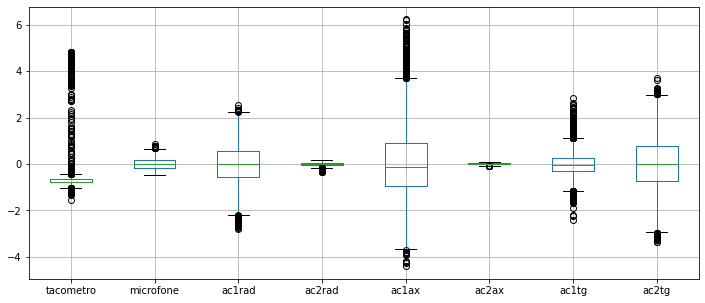

In [14]:
signals.boxplot(figsize=(12,5))
plt.show()

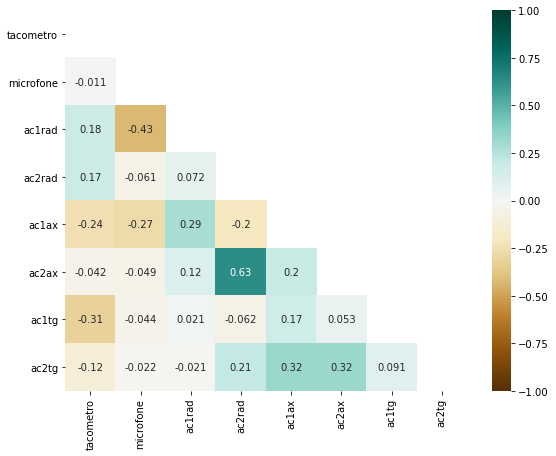

In [15]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(9,7)) 
corr = signals.corr()

mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = 'BrBG', annot = True, mask = mask)
plt.show()

## Identificando e descrevendo os sinais (no tempo e na frequência)

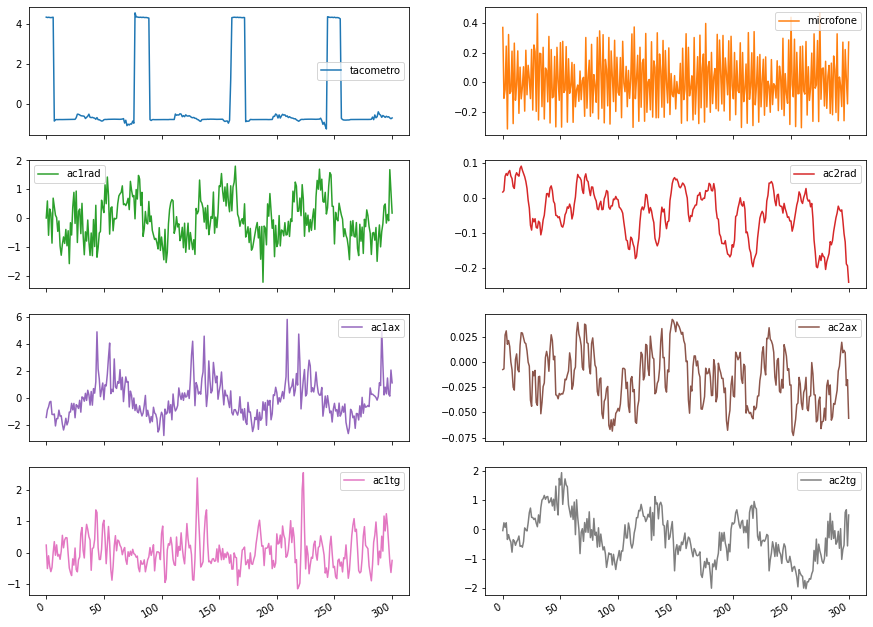

In [17]:
signals.loc[:300].plot(subplots=True, layout=(4,2), figsize=(15,12))
#signals.loc[:34].plot(subplots=True, layout=(2,4), figsize=(16,4))
plt.show()

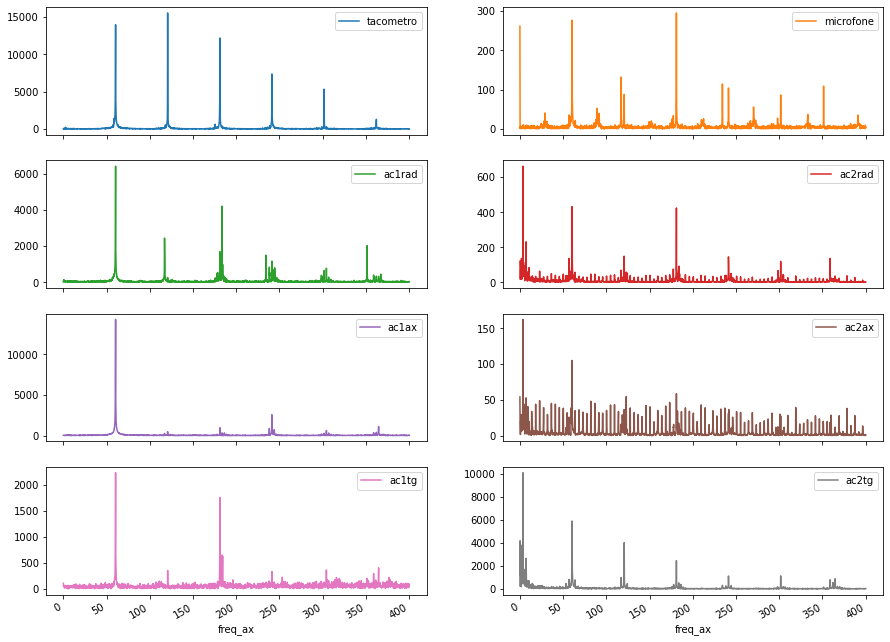

In [18]:
signals_fft.loc[:2000].plot(subplots=True, x='freq_ax', layout=(4,2), figsize=(15,12))
plt.show()

In [20]:
#import simpleaudio as sa
from IPython.display import Audio, display
for i, col in enumerate(signals_fft.columns.values[:-1]):
    print('som d@ {}'.format(col))
    display(Audio(signals[col], rate=1000))

som d@ tacometro


som d@ microfone


som d@ ac1rad


som d@ ac2rad


som d@ ac1ax


som d@ ac2ax


som d@ ac1tg


som d@ ac2tg


# Extraindo características na frequência

In [22]:
#obtenção do valor da fundamental
fft_df = signals_fft['tacometro'].copy()
candidates = [0, 0, 0]
for i in range(3):
    index = fft_df.argmax()
    candidates[i] = signals_fft.freq_ax[index]
    for j in range(-2,3):
        fft_df[index+j] = 0
        
fundamental = min(candidates)
fundamental

60.42416

In [25]:
# extraindo valores no primeiro harmônico
index = signals_fft.index[signals_fft['freq_ax'] == fundamental]
print(index)
signals_fft.iloc[index]

Int64Index([302], dtype='int64')


,tacometro,microfone,ac1rad,ac2rad,ac1ax,ac2ax,ac1tg,ac2tg,freq_ax
302,13918.871738,276.229054,6404.96679,431.71043,14266.636365,105.112756,2226.165712,5912.464178,60.42416


In [29]:
# gerando dicionário
first_h = signals_fft.iloc[index].to_dict('records')[0]
first_h.pop('tacometro')
first_h.pop('freq_ax')
first_h

{'microfone': 276.22905371381125,
 'ac1rad': 6404.9667903494765,
 'ac2rad': 431.71042978793713,
 'ac1ax': 14266.636365129269,
 'ac2ax': 105.11275624147058,
 'ac1tg': 2226.165711903757,
 'ac2tg': 5912.464178014923}

In [30]:
# adicionando sulfixo às chaves do dicionário
{k+'_1h': v for k, v in first_h.items()}

{'microfone_1h': 276.22905371381125,
 'ac1rad_1h': 6404.9667903494765,
 'ac2rad_1h': 431.71042978793713,
 'ac1ax_1h': 14266.636365129269,
 'ac2ax_1h': 105.11275624147058,
 'ac1tg_1h': 2226.165711903757,
 'ac2tg_1h': 5912.464178014923}

In [31]:
print('  Fundamental: {}\n2xFundamental: {}'.format(fundamental, 2*fundamental))

# acesso aos harmônicos, basta multiplicar o index
signals_fft.iloc[index*2]

  Fundamental: 60.42416
2xFundamental: 120.84832


,tacometro,microfone,ac1rad,ac2rad,ac1ax,ac2ax,ac1tg,ac2tg,freq_ax
604,3814.021539,23.875061,138.298677,38.5695,107.620086,7.729637,56.569306,1026.196684,120.84832


### Verificando visualmente

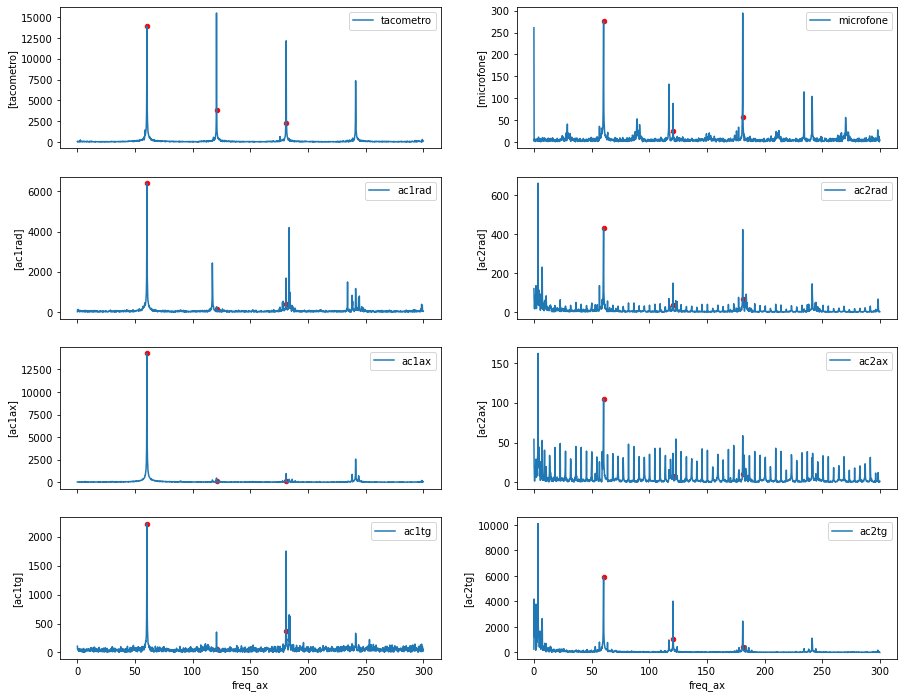

In [32]:
fig, axes = plt.subplots(4,2,figsize=(15, 12),sharex=True)
nindex = index[0]

for i, col in enumerate(signals_fft.columns.values[:-1]):
    signals_fft[:1500].plot(x='freq_ax', y=[col], ax=axes[i//2,i%2])
    signals_fft.iloc[[n*nindex for n in range(1,4)],:].plot(x='freq_ax', y=[col], 
                                                            ax=axes[i//2,i%2], kind='scatter',
                                                            color="red")
    
plt.show()

## Máquina de análise de FFT

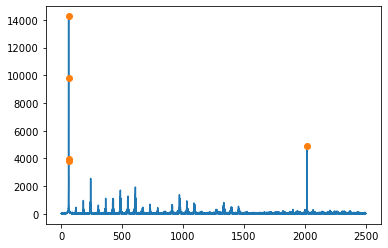

,freq,harmonic,amplitude
4,60.024,0.993,"3,800.319"
1,60.224,0.997,"9,798.210"
0,60.424,1.000,"14,266.636"
3,60.624,1.003,"3,958.817"
2,"2,020.408",33.437,"4,882.395"


In [33]:
real_fft = signals_fft['ac1ax'].values

num_max = 5 # limiar de seleção
temp = np.argpartition(-real_fft, num_max) # ordenando parte dos sinais
biggest_args = temp[:num_max] # extraindo os índices dos maiores valores de amplitude

greatest_values = pd.DataFrame({'freq':signals_fft.freq_ax[biggest_args], 
                                'harmonic': signals_fft.freq_ax[biggest_args]/fundamental,
                                'amplitude':real_fft[biggest_args]})

greatest_values.sort_values('amplitude', ascending=False, ignore_index=True, inplace=True) # organiza os índices decrescendo 
                                                                                           # amplitude do sinal

pd.options.display.float_format = '{:,.3f}'.format


# plot com zoom
max_freq = 3000
plt.plot(signals_fft.freq_ax[:max_freq*5], real_fft[:max_freq*5], 
         list(greatest_values['freq']), list(greatest_values['amplitude']), 'o')
plt.show()

# mostra tabela
greatest_values.sort_values('harmonic') # exibe na ordem de HARMONICOS crescentes
#greatest_values  # exibe na ordem de AMPLITUDES decrescentes

# Extração de dados estatísticos

## Teste: Análise de séries temporais

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [35]:
period = int(round(sampling_freq/fundamental))
period

83

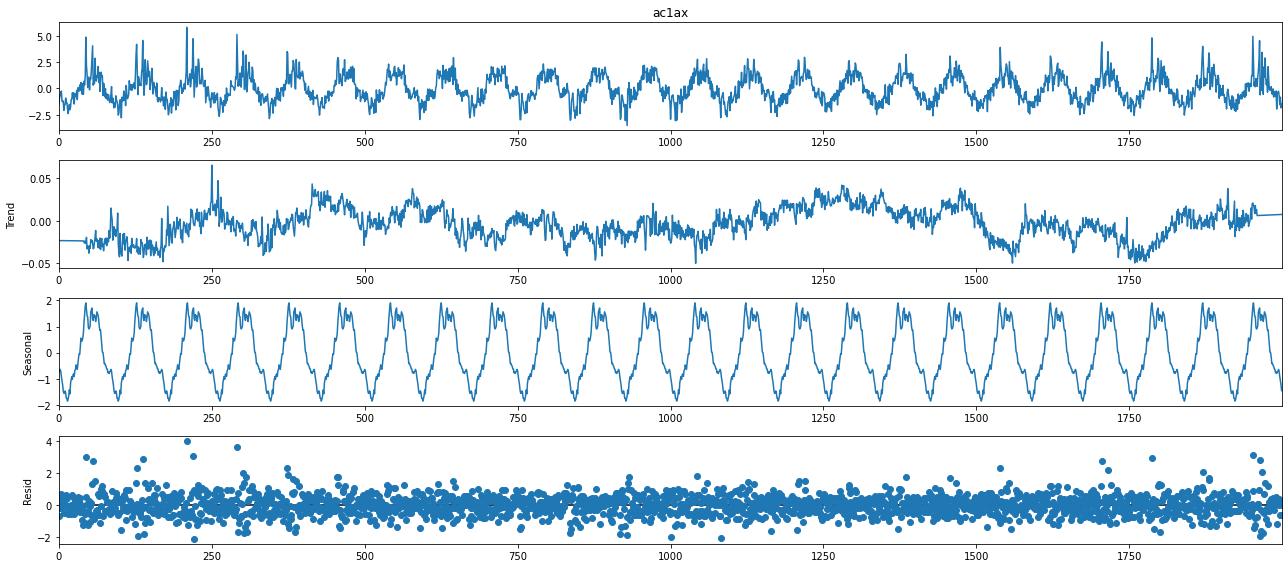

In [39]:
decomp_aditiva = seasonal_decompose(signals['ac1ax'][:2000], period=period, model='additive', extrapolate_trend='freq')
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
fig = decomp_aditiva.plot()
plt.show()

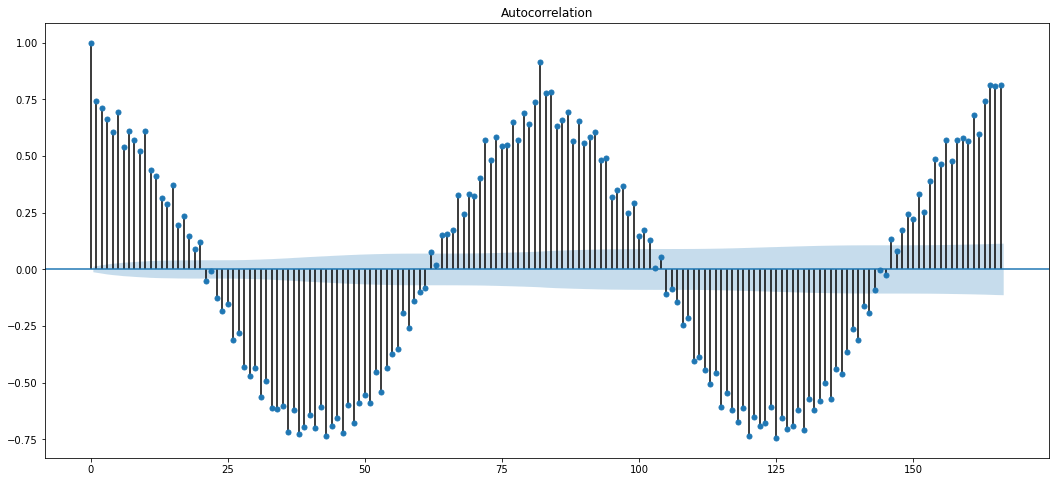

In [38]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(signals['ac1ax'], lags=2*period)
plt.show()

conclusão parcial: não dá para afirmar nada com esses modelos